In [51]:
# importing relevant packages

# generic
import numpy as np
import pandas as pd

# for training models 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# pickling models
import joblib

# finding best model
from sklearn.model_selection import GridSearchCV, cross_val_score

# plots
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# packages for model evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [6]:
# loading the data
df = pd.read_parquet('../data/cleaned/dataCleanWMedicalUrgency.parquet')

# saetting y to be the target variable
y = df['medical_urgency']

# importing the preprocessed data
X = pd.read_parquet('../data/cleaned/featuresPreprocessed.parquet')

# splitting the data
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.25, random_state=1234, stratify=y)

# resetting indices to allow models to run properly
X_rem.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_rem.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [4]:
# loading the optimised model
gridsearch_log_reg = joblib.load('../model/logistic_model_3_gridsearch_rem.pkl')

In [9]:
# setting up a series to plot most influential factors in predicting class 0
most_inf_0_pos = pd.DataFrame(gridsearch_log_reg.best_estimator_['log_reg'].coef_, columns = X_exp.columns).iloc[0, :].sort_values(ascending=False)
most_inf_0_neg = pd.DataFrame(gridsearch_log_reg.best_estimator_['log_reg'].coef_, columns = X_exp.columns).iloc[0, :].sort_values(ascending=False)
most_inf = pd.DataFrame(pd.concat([most_inf_0_pos, most_inf_0_neg]))
most_inf.reset_index(inplace=True)

# renaming columns and adding an effect column that will aid in visualisation
most_inf.rename(columns={'index': 'Attribute', 0: 'Odds ratio multiplier class 0'}, inplace=True)
most_inf['Effect'] = 'none'

In [14]:
most_inf_0_pos.head(30)

cc_suicidal                  0.590738
cc_alcoholintoxication       0.545969
cc_strokealert               0.379917
cc_psychiatricevaluation     0.363111
cc_chestpain                 0.357229
age                          0.330140
cc_alteredmentalstatus       0.297843
cc_modifiedtrauma            0.265487
cc_fulltrauma                0.252393
cc_shortnessofbreath         0.241053
cc_cardiacarrest             0.232347
cc_drugproblem               0.203411
cc_unresponsive              0.191965
cc_neurologicproblem         0.182020
cc_alcoholproblem            0.175046
cc_overdose-intentional      0.170798
cc_syncope                   0.160671
cc_poisoning                 0.151483
cc_other                     0.148689
cc_gibleeding                0.130433
cc_depression                0.129846
cc_sicklecellpain            0.129612
cc_drug/alcoholassessment    0.128323
cc_psychoticsymptoms         0.125765
cc_bodyfluidexposure         0.122807
n_admissions                 0.120508
cc_homicidal

In [15]:
most_inf_0_neg.tail(30)

cc_woundcheck             -0.107496
cc_wristpain              -0.108750
cc_footinjury             -0.108773
cc_skinirritation         -0.110097
cc_toepain                -0.110937
cc_coldlikesymptoms       -0.111721
cc_motorvehiclecrash      -0.112664
cc_ankleinjury            -0.114769
previousdispo_Discharge   -0.116514
cc_cyst                   -0.117839
cc_abdominalpain          -0.121905
cc_fingerinjury           -0.126104
cc_cough                  -0.133137
cc_fingerpain             -0.134178
cc_laceration             -0.136546
cc_handpain               -0.138234
cc_anklepain              -0.157560
cc_legpain                -0.166202
cc_abscess                -0.167325
cc_footpain               -0.175424
cc_sorethroat             -0.184857
cc_earpain                -0.185385
cc_rash                   -0.194001
cc_dentalpain             -0.206503
cc_suture/stapleremoval   -0.211562
cc_kneepain               -0.240337
cc_backpain               -0.244013
dep_name_B                -0

In [22]:
X_prod = X.loc[:, 'cc_abdominalcramping' : 'cc_wristpain']
X_prod['age'] = X['age']
X_prod['dep_name_B'] = X['dep_name_B']
X_prod['dep_name_C'] = X['dep_name_C']
X_prod['arrivalmode_Unknown'] = X['arrivalmode_Unknown']

In [ ]:
# splitting the porduction data
X_prod_rem, X_prod_test, y_rem, y_test = train_test_split(X_prod, y, test_size=0.25, random_state=1234, stratify=y)

In [49]:
X.loc[:, 'cc_abdominalcramping' : 'cc_wristpain'].sum(axis=1).value_counts()

1.0    487658
2.0     59668
3.0      7101
4.0       850
5.0       120
6.0        17
7.0         3
Name: count, dtype: int64

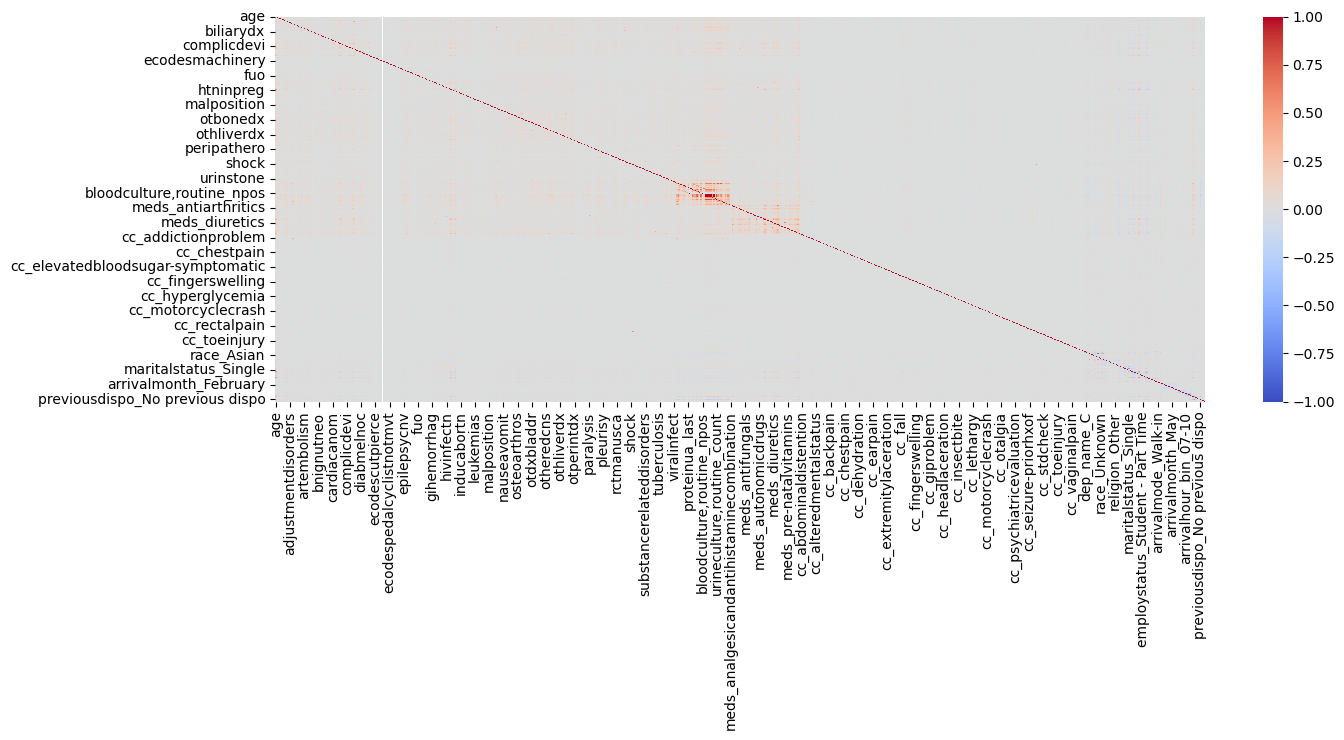

In [52]:
plt.figure(figsize=(15, 5))
sns.heatmap(X.corr(), cmap="coolwarm", vmax=1.0, vmin=-1.0)
plt.show()

## Logistic Regression

In [41]:
# setting up the estimators 
estimators = [
    ('normalise', StandardScaler()),
    ('log_reg', LogisticRegression(max_iter=10000, solver='liblinear'))
]
pipe = Pipeline(estimators)

# setting upi values for the 'C' parameter
C = [0.01, 0.1, 1, 10]
penalties = ['l1', 'l2']

params = dict(
    log_reg__C = C,
    log_reg__penalty = penalties
)

In [42]:
# setting up the grid search model 
gridsearch_model_log_reg_prod = GridSearchCV(pipe, param_grid=params, cv=5)

# fitting the girsearch
gridsearch_model_log_reg_prod.fit(X_prod_rem, y_rem)

KeyboardInterrupt: 

In [33]:
# saving the gridsearch
joblib.dump(gridsearch_model_log_reg_prod, '../model/logistic_model_prod.pkl')\

['../model/logistic_model_prod.pkl']

In [34]:
# loading the production logistic regression model
log_reg_model_prod = joblib.load('../model/logistic_model_prod.pkl')

In [35]:
log_reg_model_prod.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('log_reg',
                 LogisticRegression(C=1, max_iter=10000, solver='liblinear'))])

In [36]:
log_reg_model_prod.score(X_prod_test, y_test)

0.7159987036836988

In [ ]:
y_pred_LR = log_reg_model_prod.predict(X_prod_test)

class_report_LR = classification_report(y_test, y_pred_LR)

print(class_report_LR)                               

              precision    recall  f1-score   support

           0       0.73      0.69      0.71     42006
           1       0.68      0.69      0.69     58779
           2       0.75      0.79      0.77     38070

    accuracy                           0.72    138855
   macro avg       0.72      0.72      0.72    138855
weighted avg       0.72      0.72      0.72    138855



## XGBoost

In [28]:
# fitting a scaler 
scaler = StandardScaler()
scaler.fit_transform(X_prod_rem)
scaler.transform(X_prod_test)

# making the model 
xgboost_model = XGBClassifier()
xgboost_model.fit(X_prod_rem, y_rem)

# finding the accuracy score
xgboost_model.score(X_prod_test, y_test)

0.7236685751323323

In [53]:
joblib.dump(xgboost_model, '../model/xgboost_model_prod.pkl')

['../model/xgboost_model_prod.pkl']

In [39]:
xgb_model_prod = joblib.load('../model/xgboost_model_prod')

In [40]:
y_pred_XGB = xgb_model_prod.predict(X_prod_test)

class_report_XGB = classification_report(y_test, y_pred_XGB)

print(class_report_XGB)    

              precision    recall  f1-score   support

           0       0.75      0.66      0.71     42006
           1       0.68      0.73      0.70     58779
           2       0.76      0.78      0.77     38070

    accuracy                           0.72    138855
   macro avg       0.73      0.72      0.73    138855
weighted avg       0.73      0.72      0.72    138855



# Evaluation